In [52]:
import json
import os
import sys
import importlib
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
import src.plots

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import ttest_1samp, wilcoxon
import statannot

from statsmodels.stats.multitest import fdrcorrection, multipletests
import statsmodels as sm
import statsmodels.formula.api as smf

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')

In [2]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
class_abbrevs = json.load(open('../data/metadata/molec_class_abbrev.json'))

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

In [3]:
gb = np.power(2, data.loc[:, data_cols])
# gb = gb.drop(['1091_8_FBG', '1091_10_FBG'], axis=1) 
gb = (gb
 .T
 .join(fg[['animal', 'bg_type']])
 .groupby(['animal', 'bg_type'])
)
gb = (gb.std() / gb.mean()) * 100

# change dtype of animal index back to int
idx = gb.index
gb.index = gb.index.set_levels([idx.levels[0].astype(int), idx.levels[1]])

gb = gb.drop(1091, level='animal')

# Sort according to OGTT glucAUC order
sorter = ap.loc[ap['original'], 'Nile rat label'].sort_values().index
gb = gb.reindex(sorter, level='animal')

display(gb)

m_0        m_1        m_2        m_3         m_4  \
animal bg_type                                                            
1093   FBG       53.464270  17.880001  44.250662   8.394440   22.613023   
       RBG       39.026897  11.652806  38.806249  28.857759   51.435289   
1092   FBG       34.177809  14.478312  35.117777  10.121304  101.793867   
       RBG       23.623592  11.054094  12.752727  29.271496  101.279148   
1074   FBG       41.796211  49.819737  40.514368   9.226702  133.628845   
       RBG       49.853000  18.802471  24.756410  33.676962   16.997728   
1062   FBG       42.979048  27.955164  62.624951  30.996139  160.287064   
       RBG       19.083103  24.371803  52.503763  12.482614   23.810329   
1102   FBG       61.058866  14.404511  41.061658  14.555573  114.041335   
       RBG       70.763276  11.945092  78.894882   2.147696  104.513330   
1060   FBG      135.033146  11.724372  38.015422   9.518486  171.980900   
       RBG      109.122505  27.174735  80.128477  13.155240   88.240480   
1101   FBG       35.251797  18.784187  28.128477  17.021727   88.760300   
       RBG       38.021394   6.547001  32.433858  10.397039   68.806258   
1082   FBG       53.819767  13.035534  23.361274  18.722329   88.575586   
       RBG       72.632782  12.717651  21.561572  11.503434   90.954593   
1076   FBG       42.521250  39.558616  75.738414  29.379181  157.000903   
       RBG       92.719056   7.771533  58.085292  19.890841  107.344687   

                      m_5        m_6        m_7        m_8        m_9  ...  \
animal bg_type                                                         ...   
1093   FBG       4.130082   8.411879  11.617008  11.438302  16.488283  ...   
       RBG      13.126940  14.579750   4.443541  15.681928  10.127275  ...   
1092   FBG      13.261534  24.046540  13.658066  27.386919   7.298736  ...   
       RBG      30.385349  28.730235  31.744977  29.720533  24.070132  ...   
1074   FBG       8.430682  15.635192  56.206303  17.458921  32.239555  ...   
       RBG      23.611413  21.558153  10.817154  16.923088   5.885145  ...   
1062   FBG      27.082323  10.321457   7.961478  15.700581  27.218032  ...   
       RBG      22.673909   3.903375  20.813806   6.872019   8.850415  ...   
1102   FBG      10.581403  11.901872  19.190857  17.154349   5.827639  ...   
       RBG      11.838497   3.067916  17.539519   4.276553  13.453786  ...   
1060   FBG      20.668780  16.601535  15.573181  20.589889   8.088724  ...   
       RBG      12.514570  12.742306  25.169451  11.635403   7.380230  ...   
1101   FBG      30.739933  46.565770  35.547258  42.313600  16.411968  ...   
       RBG       8.991498   4.670655  21.596673   4.683508   7.621106  ...   
1082   FBG      18.334695  36.413534  17.034660  35.561428   6.837246  ...   
       RBG      17.183937  18.556488  13.846643  17.162169  23.161192  ...   
1076   FBG      66.918022  43.569026  51.807949  45.716528  46.971014  ...   
       RBG       7.201984   6.275901  14.192407   9.498442   6.511294  ...   

                    l_907      l_908       l_909       l_910       l_911  \
animal bg_type                                                             
1093   FBG      61.684436  82.006414   79.862391   99.452150   63.461796   
       RBG      32.352053  29.839354   36.729683   73.485602   29.681518   
1092   FBG      54.133725  81.647621   37.542374  137.967077   53.064706   
       RBG      23.840652  32.598691   33.298731   89.725561   30.831242   
1074   FBG      54.442843  50.806159   49.873126  114.926248   59.028862   
       RBG      17.060906  18.902980   30.443218   13.545431   16.917963   
1062   FBG      57.768430  40.506285   45.445081   68.452936   49.886002   
       RBG      29.641263  43.362206   46.959111   38.064287   42.031696   
1102   FBG      37.432802   9.501152   26.982010   42.319090   24.371699   
       RBG      36.782721  38.032674   35.697851   60.076389   32.702872   
1060   FBG      53.913007  62.266682   70.789872 

# 1H-NMR analysis of ICC in plasma metabolites 
https://pure.uvt.nl/ws/portalfiles/portal/31113233/MCP_Ruifang_Li_assessment_of_reproducibility_PlosOne_2019.pdf

### ICC definition
Ratio of between-subject variance to the total variance

Total variance = sum of between- and within-subject variance, 

Calculated by one-way ANOVA random effect model 


# `statsmodels` tutorial 
https://github.com/statsmodels/statsmodels/issues/6210

In [75]:
icdf = np.power(2, data[data_cols]).T.join(fg[['animal', 'week']])
# smf.mixedlm(f'')
# icdf = icdf.loc[:, data]
icdf

,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,...,l_909,l_910,l_911,l_912,l_913,l_914,l_915,l_916,animal,week
1091_8_FBG,4.331888e+05,1800018.231,1.901795e+07,3.104118e+07,1.922640e+08,8.776987e+06,6296060.890,3.338524e+06,6.766760e+06,5136893.816,...,5.933512e+04,1.411445e+05,1.437352e+05,6.983529e+05,9.980529e+04,5.516634e+05,5.584948e+05,4.029711e+05,1091,8.0
1091_10_FBG,1.987804e+05,1562786.397,1.256650e+07,2.750613e+07,1.503170e+08,9.197110e+06,6842137.116,4.546626e+06,6.769321e+06,3578884.959,...,1.340335e+05,2.145208e+05,3.578289e+05,9.782618e+05,3.154109e+05,1.150220e+06,1.046119e+06,8.991765e+05,1091,10.0
1093_8_FBG,8.962525e+04,1959617.766,1.226749e+07,2.627563e+07,1.778047e+08,9.233758e+06,6508144.965,4.619307e+06,6.653762e+06,5298706.841,...,2.791926e+05,5.516025e+05,8.259771e+05,1.336037e+06,1.457096e+06,2.610155e+06,2.775993e+06,2.191637e+06,1093,8.0
1093_9_FBG,3.196572e+05,1926378.893,5.415969e+06,2.417019e+07,1.391116e+08,9.494576e+06,6179363.357,5.808179e+06,6.486676e+06,5072950.338,...,8.438355e+05,2.369175e+06,1.811754e+06,2.782196e+06,2.266335e+06,3.027164e+06,2.826364e+06,2.051292e+06,1093,9.0
1093_10_FBG,2.721999e+05,1398263.003,6.834538e+06,2.221044e+07,1.133700e+08,8.749131e+06,7270258.001,5.070730e+06,7.955864e+06,3846522.013,...,1.981918e+05,3.922173e+05,5.316587e+05,1.063345e+06,5.068373e+05,1.136831e+06,1.216276e+06,8.163484e+05,1093,10.0
1060_8_FBG,1.979437e+05,1203471.867,1.560208e+07,2.753779e+07,1.453322e+05,6.597335e+06,4447317.879,2.761855e+06,4.388678e+06,3357743.024,...,4.038564e+05,1.644001e+06,1.052319e+06,2.095905e+06,8.970427e+05,1.500998e+06,1.593412e+06,9.364211e+05,1060,8.0
1060_9_FBG,3.676026e+06,1508476.249,2.013512e+07,2.406454e+07,5.895316e+05,9.683139e+06,5729743.460,2.813668e+06,6.076216e+06,3778966.615,...,4.509356e+05,1.373760e+06,9.115551e+05,2.724300e+06,1.191289e+06,1.670474e+06,1.810744e+06,1.233463e+06,1060,9.0
1060_10_FBG,4.402944e+05,1294504.877,8.893914e+06,2.905703e+07,1.551574e+08,7.270466e+06,6197505.320,3.612669e+06,6.647482e+06,3248736.241,...,5.698491e+04,7.512638e+04,2.233480e+05,1.073555e+06,2.498006e+05,7.775475e+05,8.938883e+05,6.364182e+05,1060,10.0
1062_8_FBG,2.806168e+05,2125023.802,3.073432e+07,2.895650e+07,3.587878e+06,9.783202e+06,5354127.562,4.091302e+06,5.333774e+06,4490185.121,...,1.030005e+05,1.470772e+05,2.416869e+05,7.455546e+05,1.941945e+05,6.675371e+05,6.193117e+05,3.933187e+05,1062,8.0
1062_9_FBG,1.599179e+05,1635717.108,1.837694e+07,2.226778e+07,9.567384e+06,7.466049e+06,5740458.059,3.756916e+06,6.307631e+06,3958483.970,...,1.442266e+05,2.560351e+05,3.293856e+05,1.000657e+06,1.835527e+05,6.792324e+05,7.010480e+05,4.170980e+05,1062,9.0


In [63]:
result = smf.mixedlm(f'l_569 ~ week', groups='animal', data=icdf.loc[rbg_cols]).fit()
cov_re = result.cov_re.values.item() 
scale = result.scale
icc = cov_re / (cov_re + scale)
# icc = result.cov_re / (result.cov_re + result.scale)
icc

0.7986127966862171

In [76]:
results = {}
# for bg_name, bg_type in [('nonfasted', rbg_cols), ('fasted', fbg_cols)]:
for feature in data.index:
    results[feature] = {}
    r = results[feature]
    nonf = smf.mixedlm(f'{feature} ~ week', groups='animal', data=icdf.loc[rbg_cols]).fit()
    cov_re = nonf.cov_re.values.item() 
    scale = nonf.scale
    nonf_icc = cov_re / (cov_re + scale)
    r['nonfasted_icc'] = nonf_icc
    r['nonfasted_week_pval'] = nonf.pvalues['week']
    r['nonfasted_animal_var_pval'] = nonf.pvalues['animal Var']
    
    fast = smf.mixedlm(f'{feature} ~ week', groups='animal', data=icdf.loc[fbg_cols]).fit()
    cov_re = fast.cov_re.values.item() 
    scale = fast.scale
    fast_icc = cov_re / (cov_re + scale)
    r['fasted_icc'] = fast_icc
    r['fasted_week_pval'] = fast.pvalues['week']
    r['fasted_animal_var_pval'] = fast.pvalues['animal Var']

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjand

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjand

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.372170
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: Use

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.288522
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linea

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.296100
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.391903
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  Con

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.302571
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Max

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\s

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.860889
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.316900
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Max

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.126758
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linea

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.239927
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linea

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.596003
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: Use

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  wa

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.062200
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWar

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.797033
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: Use

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.567058
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.472716
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.041431
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.598203
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linea

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjand

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.480783
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.503238
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.431819
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: Use

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWar

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check 

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.302439
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: Use

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  Con

C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  Conver

In [99]:
iccs = (pd.DataFrame(results)
        .T
        .join(data[['ID', 'superclass', 'molec_class', 'fa_carbons', 'fa_unsat']])
       )
iccs['color'] = iccs['superclass'].map(colors)
# iccs.to_csv('../data/processed/ICC_results.csv')

iccs = iccs.sort_values('nonfasted_icc')
iccs['xpos'] = range(len(iccs))
iccs

,nonfasted_icc,nonfasted_week_pval,nonfasted_animal_var_pval,fasted_icc,fasted_week_pval,fasted_animal_var_pval,ID,superclass,molec_class,fa_carbons,fa_unsat,color,xpos
m_183,1.010795e-10,0.620467,1.000000,1.540038e-10,0.246600,NaN,Unidentified,Unidentified,Unidentified,NaN,NaN,"[0.7265625, 0.6875, 0.671875]",0
m_339,1.065574e-10,0.180478,NaN,2.618039e-01,0.090450,0.372753,Unidentified,Unidentified,Unidentified,NaN,NaN,"[0.7265625, 0.6875, 0.671875]",1
m_393,1.125500e-10,0.104777,1.000000,1.187929e-01,0.952149,0.615018,Unidentified,Unidentified,Unidentified,NaN,NaN,"[0.7265625, 0.6875, 0.671875]",2
l_163,1.268764e-10,0.740355,NaN,1.489656e-02,0.060000,0.939570,SM d32:1,Sphingolipid,SM,32.0,1.0,"[0.9453125, 0.5546875, 0.16796875]",3
l_316,1.288176e-10,0.076283,1.000000,1.038443e-02,0.803183,0.958224,Unidentified,Unidentified,Unidentified,NaN,NaN,"[0.7265625, 0.6875, 0.671875]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_206,8.850472e-01,0.363742,0.093919,9.486444e-01,0.686780,0.091000,Unidentified,Unidentified,Unidentified,NaN,NaN,"[0.7265625, 0.6875, 0.671875]",1404
l_583,8.928151e-01,0.269578,0.092916,4.126958e-01,0.179744,0.241103,Unidentified,Unidentified,Unidentified,NaN,NaN,"[0.7265625, 0.6875, 0.671875]",1405
l_896,8.948236e-01,0.857803,0.092653,3.356033e-01,0.118713,0.301387,Unidentified,Unidentified,Unidentified,NaN,NaN,"[0.7265625, 0.6875, 0.671875]",1406
l_558,8.981757e-01,0.182117,0.092217,8.198893e-01,0.440036,0.107525,Unidentified,Unidentified,Unidentified,NaN,NaN,"[0.7265625, 0.6875, 0.671875]",1407


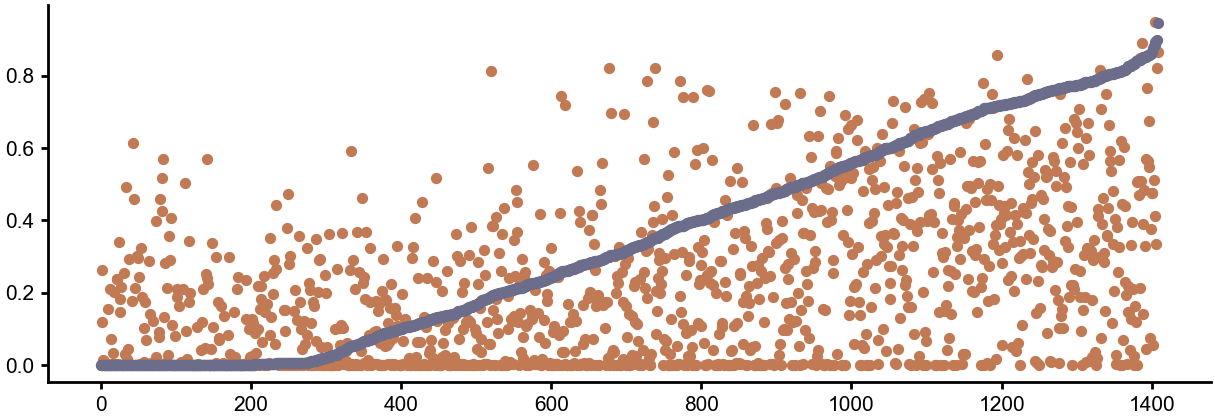

In [111]:
# subset = iccs.loc[iccs['ID'] != 'Unidentified']
# subset = subset.sort_values('nonfasted_icc')
# subset['xpos'] = range(len(subset))
subset = iccs.copy()



fig, (ax = plt.subplots(figsize=(6, 2), dpi=250)
ax.scatter(x='xpos', y='nonfasted_icc', color=colors['Fed'], data=iccs, s=5)
ax.scatter(x='xpos', y='fasted_icc', color=colors['Fasted'], data=iccs, s=5, zorder=-1)

# ax.imshow([[1,2,3], [4,5,6]])

sns.despine()

In [106]:
1004 / len(iccs)

0.7125621007806955

In [102]:
(iccs['nonfasted_icc'] > iccs['fasted_icc']).sum()

1004

<AxesSubplot:>

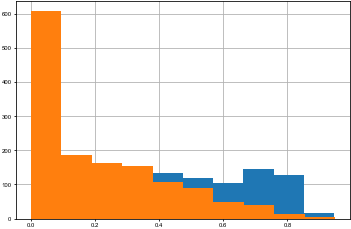

In [104]:
iccs['nonfasted_icc'].hist()
iccs['fasted_icc'].hist()

In [62]:
import numpy as np
import seaborn as sns
from scipy.stats import chi2
import statsmodels.formula.api as smf
import statsmodels.api as sm

df = sns.load_dataset('tips')

# df = sm.datasets.get_rdataset('dietox', 'geepack').data

# fit a null-model
formula = 'tip ~ 1'
null_model = smf.mixedlm(formula, data=df, groups=df.day)
results = null_model.fit(reml=False)

def get_icc(results):
    '''get the Intraclass Correlation Coefficient (ICC)'''
    icc = results.cov_re / (results.cov_re + results.scale)
    
    return icc.values[0, 0]


def lr_test(formula, data, groups):
    '''perform likelihood ratio test of random-effects'''
    # fit null model in mixed linear model
    null_model = smf.mixedlm(formula, data=data, groups=groups)\
                    .fit(reml=False)
    # fit OLS model
    ols_model = smf.ols(formula, data=data)\
                   .fit()
    # get the LRT statistic and p-value
    lrt = np.abs(null_model.llf - ols_model.llf) * 2
    p = chi2.sf(lrt, 1)
    
    return (lrt, p)

# get the ICC and LRT results
icc = get_icc(results)
lrt, p = lr_test(formula, data=df, groups='day')

print(f'ICC = {icc:.4f}')
print(f'The LRT statistic: {lrt:.4f} (p = {p:.5})')

ICC = 0.0048
The LRT statistic: 0.1458 (p = 0.70259)


C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\bjanderson23\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
